<h1>1.  Amazon Fine Food Reviews Analysis Using Naive Bayes.</h1>


    Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews 

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

* Number of reviews: 568,454<br>
* Number of users: 256,059<br>
* Number of products: 74,258<br>
* Timespan: Oct 1999 - Oct 2012<br>
* Number of Attributes/Columns in data: 10 

### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful i.e(Yes)
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not i.e (Yes+No)
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


<h2> 2. Data Loading </h2>

The dataset is available in CSV forms

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /opt/conda/envs/py3.6/lib/python3.6/site-packages (10.0.1)
jupyter 1.0.0 requires qtconsole, which is not installed.
ipywidgets 7.0.3 has requirement widgetsnbextension~=3.0.0, but you'll have widgetsnbextension 3.2.0 which is incompatible.


In [2]:
!pip install nltk

jupyter 1.0.0 requires qtconsole, which is not installed.
ipywidgets 7.0.3 has requirement widgetsnbextension~=3.0.0, but you'll have widgetsnbextension 3.2.0 which is incompatible.


In [3]:
!pip install seaborn

jupyter 1.0.0 requires qtconsole, which is not installed.
ipywidgets 7.0.3 has requirement widgetsnbextension~=3.0.0, but you'll have widgetsnbextension 3.2.0 which is incompatible.


In [4]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


import re
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

zf=zipfile.ZipFile('Reviews.zip')
filtered_data=pd.read_csv(zf.open('Reviews.csv'))


/opt/conda/envs/py3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [7]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


<h1> 3. Data Cleaning: Deduplication.</h1>

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True,
                                      inplace=False, kind='quicksort',
                                      na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName",
                                          "Time","Text"}, keep='first',
                                  inplace=False)
final.shape

(393933, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.29901100176971

<b>Observation:-</b> It was also seen that in two rows, the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(393931, 10)


positive    336824
negative     57107
Name: Score, dtype: int64

<h1> 4.Text Preprocessing: Stemming, stop-word removal and Lemmatization. </h1>

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
#Defining function to remove HTML tags and Punctuation marks in the review

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
print(stop)

{'when', 'some', "shan't", 'its', 'no', 'theirs', "should've", 'aren', 'more', 'in', 'hadn', "weren't", 'both', 'her', 'ma', 'yourself', 'him', 't', "mustn't", "mightn't", 'himself', "you'd", 'yours', 'too', 'same', 'why', 'here', 'ours', 'most', "don't", 'after', 'with', 'ourselves', 'doesn', 'how', 'very', 'we', 'can', "haven't", 'few', 'mustn', 'll', 'wouldn', 'herself', 'does', 'a', 'i', 'shan', 'hasn', 'couldn', 'will', 'it', 'other', "didn't", 'where', 'about', 'who', "she's", "you're", 'but', 'any', 'm', 'isn', "won't", 'his', "that'll", 'not', 'are', 'the', 's', 'what', 'weren', 'and', 'down', 'just', "hasn't", "you've", 'such', 'yourselves', 'do', "couldn't", 'don', 'me', 'there', 'were', 'by', 'during', 'between', 'below', 'up', 'this', 'before', 'didn', 'y', "wasn't", 'all', 'being', 'he', 'them', 'had', 'ain', 'have', 'these', 'then', 'as', "hadn't", 'hers', 'mightn', 'itself', 'to', 'having', 'above', 'be', 'until', 'from', 'is', 'those', 'because', 'off', "aren't", 'whom'

This is above list of stop-words that are present in English.But if we closely observe the above list we would see that "couldn't","not","won't" etc are consider as stopwords which actually provides great meaning to the sentences<br>.

Therefore we must exclude such words from our list of stopwords.

In [13]:
stop={'haven', 'further', 'when', 'those', 'only',
      'i', 'o', 'above', 'were', 'ourselves', "you'll",
      'having', 'then', 'll', 'your', "you're",'there',
      "she's", 'will', 'the','whom', 'be', 'some', 'through',
      'their', 'up', 'had', 'he', 'both', 'down',
      'all', 'these', 'during','of','themselves',"it's",
      'that', 'over','doing','at', 'but', 'here', 're','own',
      'yourself', 'until','itself', 'just', 'our','him', 's',
      'my', 'does', 'for', 'being','have', 'it', 'very', 'she',
      'more', 'again', 'off','do','are','who', 'her','shan', 'each',
      'after', 'how', 'am','if','most', 'theirs', 'don', 'myself',
      'from', "should've",'once',"you'd", 'you','between', 'herself',
      'too', 'ours', 'because','himself','they', 'with', 't', 'an',
      'few', 'in', 'yourselves','what', 've', 'where', 'below','to',
      'now', 'me',"that'll", 'why', 'other','y', 'did', 'its', 'or',
      'before', 'about','should', 'any', 'out','can','has', 'same',
      'a', 'as','d', 'so', "you've", 'is', 'which', 'on', 'his', 'we',
      'them', 'yours', 'been', 'this', 'won', 'than', 'm','by', 'ma',
      'was', 'hers', 'into','while','and', 'such', 'under'}

In [50]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)   
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews   
                else:
                    continue
            else:
                continue 
    str1 = (b" ".join(filtered_sentence)).decode() #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [15]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

print(final.head(3)) #below the processed review can be seen in the CleanedText Column 


            Id   ProductId          UserId            ProfileName  \
150528  150529  0006641040   A25ACLV5KPB4W    Matt Hetling "Matt"   
150506  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   
150505  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
150528                     0                       1  positive  1108425600   
150506                     1                       1  positive  1191456000   
150505                     1                       1  positive  1194739200   

                                           Summary  \
150528                 Nice cadence, catchy rhymes   
150506               chicken soup with rice months   
150505  Love the book, miss the hard cover version   

                                                     Text  \
150528  In June<br />I saw a charming group<br />of ro...   
150506  This is a fun way for children to learn their ...   
150505  I 

Now we have obtained data after pre-processing it.i.e Data cleaning,Text pre-processing etc.Now lets convert this cleaned text into vectors by applying Bag of Words(BoW),Term Frequency Inverse Document Frequency(TF-IDF),Word2Vec and Average Word2Vec.

<h1>5. Time stamping </h1>

Before using this data we would sort the entire data based on time stamp

In [16]:
final_sorted=final.sort_values(by=['Time'])
final_sorted.shape

(393931, 11)

In [17]:
def Rates(tn,fp,fn,tp):
    TPR=float(tp/(tp+fn))
    TNR=float(tn/(tn+fp))
    FPR=float(fp/(tn+fp))
    FNR=float(fn/(tp+fn))
    print("True Positive Rate or Sensitivity = %f" %(TPR*100))
    print("True Negative Rate or Specificity = %f" %(TNR*100))
    print("False Positive Rate or Fall-out = %f" %(FPR*100))
    print("False Negative Rate or Missclassification rate = %f" %(FNR*100))

<h1>6. Bag of Words (BoW) </h1>

Now lets apply Bag of Words to our cleaned sorted text, to convert text into corresponding vectors

In [30]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_sorted['CleanedText'].values)


In [31]:
final_counts.get_shape()

(393931, 74585)

There are total almost 393k data points with around 74.5k dimensions.

Splitting the entire datasets into <b>70% train data and 30% test data</b>

In [32]:
X_train, X_test, y_train, y_test = train_test_split(final_counts, 
                                                             final_sorted['Score'],test_size=0.3,
                                                             random_state=0)

For performing Cross-Validation we would be using <b>3-fold CV </b> and the values of alpha would be from<b> 0.1 to 1</b>

In [33]:
ap=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
ap

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [34]:
#values_alpha=[{'alpha':ap}]
cv_scores=[]
# perform 3-fold cross validation
for a in ap:
    NB= MultinomialNB(alpha=a)
    scores = cross_val_score(NB, X_train, y_train, cv=3, scoring='accuracy',n_jobs=1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_a = ap[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %f.' % optimal_a)



The optimal value of alpha is 1.000000.


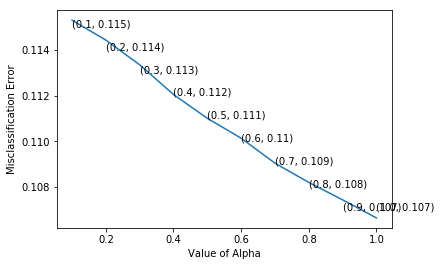

In [35]:
# plot misclassification error vs k 
plt.plot(ap, MSE)

for xy in zip(ap, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of Alpha')
plt.ylabel('Misclassification Error')
plt.show()

<b> Applying Multinomial Naive Bayes to the training data by using optimal value of alpha</b>.

In [36]:
clf = MultinomialNB(alpha=optimal_a)
clf.fit(X_train,y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [37]:
Y_pred=clf.predict(X_test)

In [38]:
X=clf.score(X_test,y_test)
X

0.89103909290912164

The <b>accuracy</b> of the model using Multinomial Naive Bayes using <b>Bag of Words</b> representation is found to be <b>89.10%</b>

In [39]:
tn, fp, fn, tp =confusion_matrix(y_test, Y_pred).ravel()
Rates(tn,fp,fn,tp)

True Positive Rate or Sensitivity = 93.436844
True Negative Rate or Specificity = 63.651698
False Positive Rate or Fall-out = 36.348302
False Negative Rate or Missclassification rate = 6.563156


In [40]:
x=confusion_matrix(y_test, Y_pred)
cm_df=pd.DataFrame(x,index=[0,1],columns=[0,1])

<h2> 6.1 Confusion Matrix for Bag of Words(BoW) </h2>

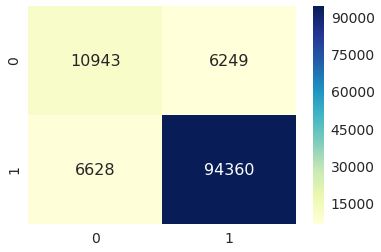

In [41]:
sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")

In [42]:
precision_score=tp/(tp+fp)
precision_score

0.93788826049359397

The <b>precision score </b> of the model using Multinomial Naive Bayes using <b>Bag of Words</b> representation is found to be <b>93.78%</b>

In [43]:
recall_score=tp/(tp+fn)
recall_score

0.93436843981463147

The <b>recall score</b> of the model using Multinomial Naive Bayes using <b>Bag of Words</b> representation is found to be <b>93.43%</b>

In [ ]:
f1_score=(2*precision_score*recall_score)/(precision_score+recall_score)
f1_score

The <b>f1-score</b> of the model using Multinomial Naive Bayes using <b>Bag of Words</b> representation is found to be <b>93.61%</b>

In [45]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers?
#utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names),reverse=True)
    coefs_with_fns=coefs_with_fns[:n]
    #top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1)in coefs_with_fns:
        print ("\t%.4f\t%-15s\t" % (coef_1, fn_1))

<h2> 6.2 Words with higher probability for positive.</h2>

In [68]:
show_most_informative_features(CountVectorizer().fit(all_positive_words), clf, n=20)

	-5.1195	hola           	
	-5.1280	viscus         	
	-5.1292	mmmmmm         	
	-5.1435	methylisothiaszolinon	
	-5.1456	petrolum       	
	-5.1555	helwig         	
	-5.2074	genteel        	
	-5.2322	volvic         	
	-5.2337	cookabl        	
	-5.3181	saltimbocca    	
	-5.4258	poper          	
	-5.4975	yellowi        	
	-5.5964	mozzrella      	
	-5.6158	halfdozen      	
	-5.6696	ryvita         	
	-5.6810	carameley      	
	-5.7086	gizard         	
	-5.7361	bitz           	
	-5.7452	practict       	
	-5.7541	sherbert       	


<h2> 6.3 Words with higher probability for negative. </h2>

In [69]:
show_most_informative_features(CountVectorizer().fit(all_negative_words), clf, n=20)

	-5.1195	warm           	
	-5.1555	uwajimaya      	
	-5.2074	standalon      	
	-5.2337	ita            	
	-5.6158	turmoil        	
	-5.6810	featur         	
	-5.7086	subsitut       	
	-5.7361	cummun         	
	-5.7950	spacer         	
	-5.8013	beagl          	
	-5.8136	progres        	
	-5.8302	perla          	
	-5.9120	poivr          	
	-5.9641	phillipin      	
	-5.9686	honeyroast     	
	-5.9841	cindi          	
	-5.9965	bancha         	
	-6.0294	cuter          	
	-6.1002	nexium         	
	-6.1445	mouldi         	


<h1> 7. TF-IDF </h1>

Now lets apply TF-IDF to our cleaned sorted text, to convert text into corresponding vectors

In [52]:
#TF-IDF
tf_idf_vect = TfidfVectorizer()
tf_idf = tf_idf_vect.fit_transform(final_sorted['CleanedText'].values)


In [53]:
tf_idf.get_shape()

(393931, 74585)

There are total almost 364k data points with around 74.5k dimensions.

Splitting the entire datasets into <b>70% train data and 30% test data</b>

In [54]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf, 
                                                             final_sorted['Score'],test_size=0.3,
                                                             random_state=0)

For performing Cross-Validation we would be using <b>3-fold CV </b> and the values of alpha would be from<b> 0.1 to 1</b>

In [55]:
ap=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


In [56]:
cv_scores=[]
# perform 3-fold cross validation
for a in ap:
    NB= MultinomialNB(alpha=a)
    scores = cross_val_score(NB, X_train, y_train, cv=3, scoring='accuracy',n_jobs=1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_a = ap[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %f.' % optimal_a)



The optimal value of alpha is 0.100000.


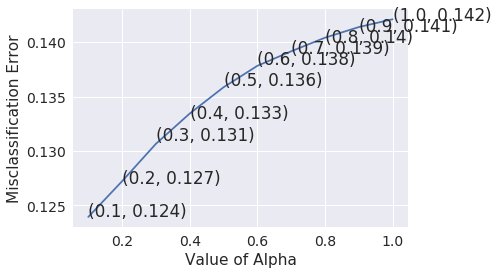

In [57]:
# plot misclassification error vs k 
plt.plot(ap, MSE)

for xy in zip(ap, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of Alpha')
plt.ylabel('Misclassification Error')
plt.show()

<b> Applying Multinomial Naive Bayes to the training data by using optimal value of alpha</b>.

In [58]:
clf = MultinomialNB(alpha=optimal_a)
clf.fit(X_train,y_train)
Y_pred=clf.predict(X_test)

In [59]:
X=clf.score(X_test,y_test)
X

0.87673041123709594

The <b>accuracy</b> of the model using Multinomial Naive Bayes using <b>TF-IDF</b> representation is found to be <b>87.67%</b>

In [60]:
tn, fp, fn, tp =confusion_matrix(y_test, Y_pred).ravel()
Rates(tn,fp,fn,tp)

True Positive Rate or Sensitivity = 99.243474
True Negative Rate or Specificity = 19.706840
False Positive Rate or Fall-out = 80.293160
False Negative Rate or Missclassification rate = 0.756526


In [61]:
x=confusion_matrix(y_test, Y_pred)
cm_df=pd.DataFrame(x,index=[0,1],columns=[0,1])

<h2> 7.1 Confusion Matrix for TF-IDF  </h2>

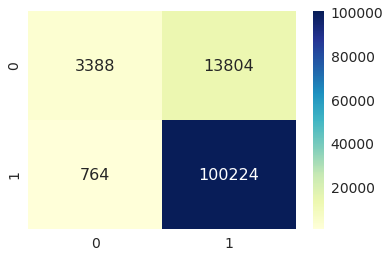

In [62]:
sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")

In [63]:
precision_score=tp/(tp+fp)
precision_score

0.87894201424211593

The <b>precision score </b> of the model using Multinomial Naive Bayes using <b>TF-IDF</b> representation is found to be <b>87.89%</b>

In [64]:
recall_score=tp/(tp+fn)
recall_score

0.99243474472214521

The <b>recall score</b> of the model using Multinomial Naive Bayes using <b>TF-IDF</b> representation is found to be <b>99.24%</b>

In [65]:
f1_score=(2*precision_score*recall_score)/(precision_score+recall_score)
f1_score

0.93224690255608889

The <b>f1-score</b> of the model using Multinomial Naive Bayes using <b>TF-IDF</b> representation is found to be <b>93.22%</b>

<h2> 7.2 Words with higher Probability for positive </h2>

In [70]:
show_most_informative_features(TfidfVectorizer().fit(all_positive_words), clf, n=20)

	-5.1195	hola           	
	-5.1280	viscus         	
	-5.1292	mmmmmm         	
	-5.1435	methylisothiaszolinon	
	-5.1456	petrolum       	
	-5.1555	helwig         	
	-5.2074	genteel        	
	-5.2322	volvic         	
	-5.2337	cookabl        	
	-5.3181	saltimbocca    	
	-5.4258	poper          	
	-5.4975	yellowi        	
	-5.5964	mozzrella      	
	-5.6158	halfdozen      	
	-5.6696	ryvita         	
	-5.6810	carameley      	
	-5.7086	gizard         	
	-5.7361	bitz           	
	-5.7452	practict       	
	-5.7541	sherbert       	


<h2> 7.3 Words with higher Probability for negative </h2>

In [71]:
show_most_informative_features(TfidfVectorizer().fit(all_negative_words), clf, n=20)

	-5.1195	warm           	
	-5.1555	uwajimaya      	
	-5.2074	standalon      	
	-5.2337	ita            	
	-5.6158	turmoil        	
	-5.6810	featur         	
	-5.7086	subsitut       	
	-5.7361	cummun         	
	-5.7950	spacer         	
	-5.8013	beagl          	
	-5.8136	progres        	
	-5.8302	perla          	
	-5.9120	poivr          	
	-5.9641	phillipin      	
	-5.9686	honeyroast     	
	-5.9841	cindi          	
	-5.9965	bancha         	
	-6.0294	cuter          	
	-6.1002	nexium         	
	-6.1445	mouldi         	


<h1> 8. Word2Vec (W2V) </h1>

In [47]:
!pip install gensim

jupyter 1.0.0 requires qtconsole, which is not installed.
ipywidgets 7.0.3 has requirement widgetsnbextension~=3.0.0, but you'll have widgetsnbextension 3.2.0 which is incompatible.


Now lets apply Avg Word2Vec to our cleaned sorted text, to convert text into corresponding vectors

In [48]:
# Training your own Word2Vec model using your own text corpus


#First creating a list of words in sentences.

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim

i=0
list_of_sent=[]
for sent in final_sorted['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [49]:
# Training our own Word2Vec model using text corpus
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=300, workers=4)    


In [50]:
np.seterr(divide='ignore', invalid='ignore')
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

393931
300


In [51]:
sent_vectors=pd.DataFrame(sent_vectors)

In [52]:
from sklearn.preprocessing import Imputer
imputer=Imputer()
sent_vectors=imputer.fit_transform(sent_vectors)

There are total almost 364k data points with around 300 dimensions.

Splitting the entire datasets into <b>70% train data and 30% test data</b>

In [53]:
X_train, X_test, y_train, y_test = train_test_split(sent_vectors, 
                                                             final_sorted['Score'],test_size=0.3,
                                                             random_state=0)

For performing Cross-Validation we would be using <b>3-fold CV </b> and the values of alpha would be from<b> 0.1 to 1</b>

In [54]:
ap=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [55]:
cv_scores=[]
# perform 3-fold cross validation
for a in ap:
    NB= MultinomialNB(alpha=a)
    scores = cross_val_score(NB, abs(X_train), y_train, cv=3, scoring='accuracy',n_jobs=1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_a = ap[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %f.' % optimal_a)




The optimal number of neighbors is 0.100000.


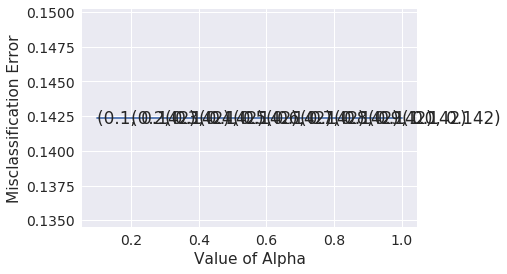

In [56]:
# plot misclassification error vs k 
plt.plot(ap, MSE)

for xy in zip(ap, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of Alpha')
plt.ylabel('Misclassification Error')
plt.show()

<b> Applying Multinomial Naive Bayes to the training data by using optimal value of alpha</b>.

In [57]:
clf = MultinomialNB(alpha=optimal_a)
clf.fit(abs(X_train),y_train)
Y_pred=clf.predict(X_test)

In [58]:
X=clf.score(X_test,y_test)
X

0.85456083939752914

The <b>accuracy</b> of the model using Multinomial Naive Bayes using <b>Avg Word2Vec</b> representation is found to be <b>85.54%</b>

In [59]:
tn, fp, fn, tp =confusion_matrix(y_test, Y_pred).ravel()
Rates(tn,fp,fn,tp)

True Positive Rate or Sensitivity = 99.989108
True Negative Rate or Specificity = 0.087250
False Positive Rate or Fall-out = 99.912750
False Negative Rate or Missclassification rate = 0.010892


<h2> 8.1 Confusion Matrix for W2Vec </h2>

In [60]:
x=confusion_matrix(y_test, Y_pred)
cm_df=pd.DataFrame(x,index=[0,1],columns=[0,1])

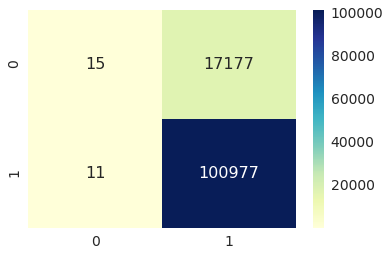

In [61]:
sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")

In [62]:
precision_score=tp/(tp+fp)
precision_score

0.85462193408602327

The <b>precision score </b> of the model using Multinomial Naive Bayes using <b>Avg Word2Vec</b> representation is found to be <b>85.46%</b>

In [63]:
recall_score=tp/(tp+fn)
recall_score

0.99989107616746542

The <b>recall score</b> of the model using Multinomial Naive Bayes using <b>Avg Word2Vec</b> representation is found to be <b>99.98%</b>

In [64]:
f1_score=(2*precision_score*recall_score)/(precision_score+recall_score)
f1_score

0.92156683794069605

The <b>f1-score</b> of the model using Multinomial Naive Bayes using <b>Avg Word2Vec</b> representation is found to be <b>92.15%</b>

<h1> 9. TF-IDF Weighted Word2Vec </h1>

Now lets apply TF-IDF Word2Vec to our cleaned sorted text, to convert text into corresponding vectors

In [65]:
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

In [66]:
#TF-IDF weighted Word2Vec

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
           
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [69]:
tfidf_sent_vectors=pd.DataFrame(tfidf_sent_vectors)

In [70]:
from sklearn.preprocessing import Imputer
imputer=Imputer()
tfidf_sent_vectors=imputer.fit_transform(tfidf_sent_vectors)

There are total almost 364k data points with around 300 dimensions.

Splitting the entire datasets into <b>70% train data and 30% test data</b>

In [71]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_sent_vectors, 
                                                             final_sorted['Score'],test_size=0.3,
                                                             random_state=0)

For performing Cross-Validation we would be using <b>3-fold CV </b> and the values of alpha would be from<b> 0.1 to 1</b>

In [72]:
ap=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [73]:
cv_scores=[]
# perform 3-fold cross validation
for a in ap:
    NB= MultinomialNB(alpha=a)
    scores = cross_val_score(NB, abs(X_train), y_train, cv=3, scoring='accuracy',n_jobs=1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_a = ap[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %f.' % optimal_a)




The optimal value of alpha is 0.100000.


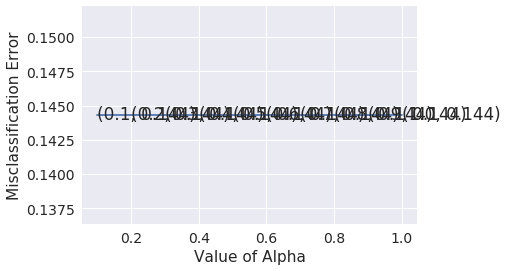

In [74]:
# plot misclassification error vs k 
plt.plot(ap, MSE)

for xy in zip(ap, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of Alpha')
plt.ylabel('Misclassification Error')
plt.show()

<b> Applying Multinomial Naive Bayes to the training data by using optimal value of alpha</b>.

In [75]:
clf = MultinomialNB(alpha=optimal_a)
clf.fit(abs(X_train),y_train)
Y_pred=clf.predict(X_test)

In [76]:
X=clf.score(X_test,y_test)
X

0.85438314435606699

The <b>accuracy</b> of the model using Multinomial Naive Bayes using <b>TF-IDF Word2Vec</b> representation is found to be <b>85.43%</b>

In [77]:
tn, fp, fn, tp =confusion_matrix(y_test, Y_pred).ravel()
Rates(tn,fp,fn,tp)

True Positive Rate or Sensitivity = 99.970294
True Negative Rate or Specificity = 0.075617
False Positive Rate or Fall-out = 99.924383
False Negative Rate or Missclassification rate = 0.029706


In [78]:
x=confusion_matrix(y_test, Y_pred)
cm_df=pd.DataFrame(x,index=[0,1],columns=[0,1])

<h2> 9.1 Confusion Matrix for (TF-IDF Word2Vec) </h2>

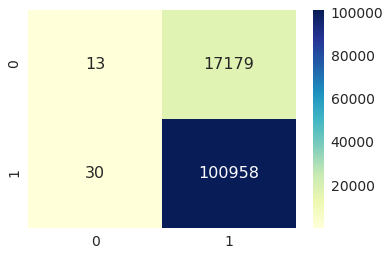

In [79]:
sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")

In [80]:
precision_score=tp/(tp+fp)
precision_score

0.85458408457976753

The <b>precision score </b> of the model using Multinomial Naive Bayes using <b>TF-IDF Word2vec</b> representation is found to be <b>85.45%</b>

In [81]:
recall_score=tp/(tp+fn)
recall_score

0.99970293500217844

The <b>recall score</b> of the model using Multinomial Naive Bayes using <b>TF-IDF Word2Vec</b> representation is found to be <b>99.97%</b>

In [82]:
f1_score=(2*precision_score*recall_score)/(precision_score+recall_score)
f1_score

0.92146491728465474

The <b>f1-score</b> of the model using Multinomial Naive Bayes using <b>TF-IDF Word2Vec</b> representation is found to be <b>92.14%</b>

<h1>10.  Conclusions </h1>

* Multinomial Naive Bayes is applied to Amazon food reviews data sets.
* The review text is converted into vectors using BoW,TF-IDF,Word2Vec,TF-IDF Word2Vec.
* The accuracy, precision, recall and f1-score for all the methods is shown below.

* Method----------------Accuracy(%)-------------Precision(%)----------Recall(%)---------F1-Score(%)  
* Bow--------------------------89.10---------------------93.78---------------93.43--------------93.61       
* TF-IDF----------------------87.67---------------------87.89---------------99.24--------------93.22
* Word2Vec------------------85.54---------------------85.46---------------99.98--------------92.15
* TF-IDF Word2Vec--------85.43--------------------85.45---------------99.97--------------92.14 